# Independent component analysis

Here we'll learn about indepednent component analysis (ICA), a matrix decomposition method that's an alternative to PCA.

In [1]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.spatial import distance
import seaborn as sns
from sklearn.decomposition import FastICA, PCA 

sns.set(style='white', context='notebook')

%matplotlib inline



/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Independent Component Analysis (ICA)

ICA was originally created for the "cocktail party problem" for audio processing. It's an incredible feat that our brains are able to filter out all these different sources of audio, automatically!

![](figures/Cocktail-party-_2502341b.jpg)
(I really like how smug that guy looks - it's really over the top)
[Source](http://www.telegraph.co.uk/news/science/science-news/9913518/Cocktail-party-problem-explained-how-the-brain-filters-out-unwanted-voices.html)

### Cocktail party problem

Given multiple sources of sound (people talking, the band playing, glasses clinking), how do you distinguish independent sources of sound? Imagine at a cocktail party you have multiple microphones stationed throughout, and you get to hear all of these different sounds. 

![](figures/independent-component-analysis-ica-the-cocktail-party-problem-n.jpg)

[Source](http://www.slideserve.com/vladimir-kirkland/ica-and-isa-using-schweizer-wolff-measure-of-dependence)

### What if you applied PCA to the cocktail party problem?

What would you get if you 

Example adapted from the excellent [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html).

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


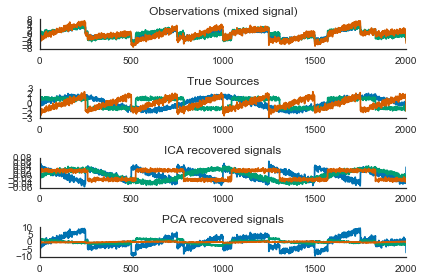

In [2]:

###############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = sns.color_palette('colorblind')

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
sns.despine()
plt.show()


### Discussion

1. What do you get when you apply PCA to the cocktail party problem? 
2. What is the difference between “orthogonal” features (PCA) and “independent” features (ICA)? Indicate all that apply. 
    - Orthogonal features explain distinct gene expression patterns
    - Orthogonal features describe average gene expression patterns
    - Independent features explain distinct gene expression patterns
    - Independent features describe average gene expression patterns
    - Orthogonal features can correlate with each other, independent features do not.
    - Independent features can correlate with each other, orthogonal features do not.

## PCA vs ICA

Which one should you use? Well, that depends on your question :)

PCA and ICA have different goals. PCA wants to find the things that change the greatest across your data, and ICA wants to find individual signals. Let's take a look at this by running both PCA and ICA on data that we're all familiar with - faces!

The "Olivetti Faces Dataset" is a commonly use face recognition dataset in machine learning.

Dataset consists of 400 faces


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


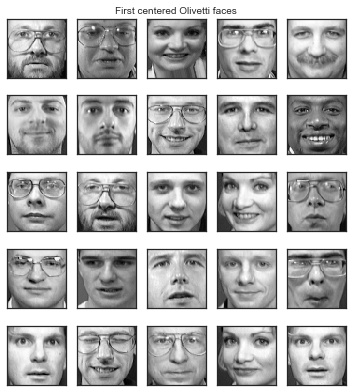

In [3]:
# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition


image_shape = (64, 64)
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

###############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)





###############################################################################
def plot_gallery(title, images, n_col=5, n_row=5, cmap=plt.cm.viridis):
    plt.figure(figsize=(2. * n_col/2, 2.26 * n_row/2))
    plt.suptitle(title)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        if comp.min() < 0:
            vmax = max(comp.max(), -comp.min())
            vmin = -vmax
        else:
            vmin = comp.min()
            vmax = comp.max()
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

    
    

###############################################################################
# Plot a sample of the input data



plot_gallery("First centered Olivetti faces", faces[:25], cmap=plt.cm.gray)


The first figure and its subpanels show the first 20 (out of 400) faces in the dataset. 

So now let's explore!

done in 0.131s


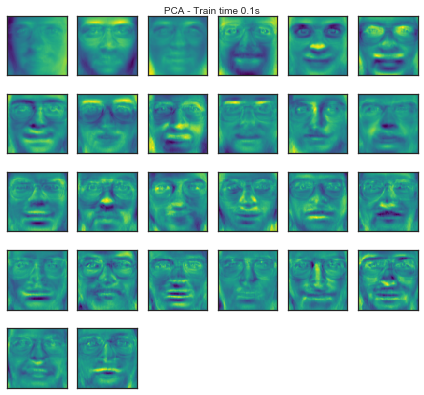

In [4]:
def explore_pca_ica(algorithm, n_components):
    
    # establish size of the figure to plot by the number
    # of rows and columns of subplots
    n_row = 1
    n_col = 1
    while n_row * n_col < n_components:
        if n_col > n_row:
            n_row += 1
        else:
            n_col += 1
            
    
    kwargs = dict(whiten=True, n_components=n_components)
    if algorithm == 'PCA':
        decomposer = PCA(**kwargs)
    elif algorithm == 'ICA':
        kwargs['random_state'] = 2016
        kwargs['max_iter'] = 200
        kwargs['tol'] = 0.001
        decomposer = FastICA(**kwargs)
    
    t0 = time()
    decomposer.fit(X=faces_centered)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    
    plot_gallery('%s - Train time %.1fs' % (algorithm, train_time),
                 decomposer.components_[:n_components], n_col=n_col, n_row=n_row)


ipywidgets.interact(explore_pca_ica,
                   algorithm=ipywidgets.Dropdown(options=['PCA', 'ICA'], value='PCA',
                                                  description='Matrix decomposition algorithm'),
                   n_components=ipywidgets.IntSlider(min=2, max=50, value=12));


This plot shows you the *components* of the data. 

Notice that in PCA, these are "eigenfaces," that is, the first face is the most average face that explains most of the data. The next components shows where the next largest amount of variance is. As you continue, the components of PCA goes into the edge cases of the different faces so you can reconstruct more and more faces.

For ICA, we don't get an "eigenface." Instead, ICA goes right into the discrete signals. Notice that some of the ICA components actually look like an individual person's face, not an average of people's faces. ICA is pulling out individual people who had their photo taken multiple times in the dataset, and reconstructing them.

### Exercise 2

Discuss the questions below while you play with the sliders.

1. How does the number of components influence the decomposition by PCA? (indicate all that apply)
    - You get to see more distinct signals in the data
    - It changes the components
    - It doesn't affect the first few components
    - You get to see more of the "special cases" in the variation of the data
2. How does the number of components influence the decomposition by ICA? (indicate all that apply)
    - You get to see more distinct signals in the data
    - It changes the components
    - It doesn't affect the first few components
    - You get to see more of the "special cases" in the variation of the data
3. What does the first component of PCA represent? (Check all that apply)
    - The features that change the most across the data
    - One distinct subset of features that appears independently of all other features
    - The axis of the "loudest" features in the dataset
    - A particular set of facial features that appear together and not with other features
3. What does the first component of ICA represent? (Check all that apply)
    - The features that change the most across the data
    - One distinct subset of features that appears independently of all other features
    - The axis of the "loudest" features in the dataset
    - A particular set of facial features that appear together and not with other features

#### The punchline

Which should you use, PCA or ICA? Again, it depends on your question!

PCA tells you which are the largest varying genes in your data. ICA tells you which genes contribute to discrete signals from specific populations in your data. Let's look at some more biologically relevant (though still small) datasets.

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


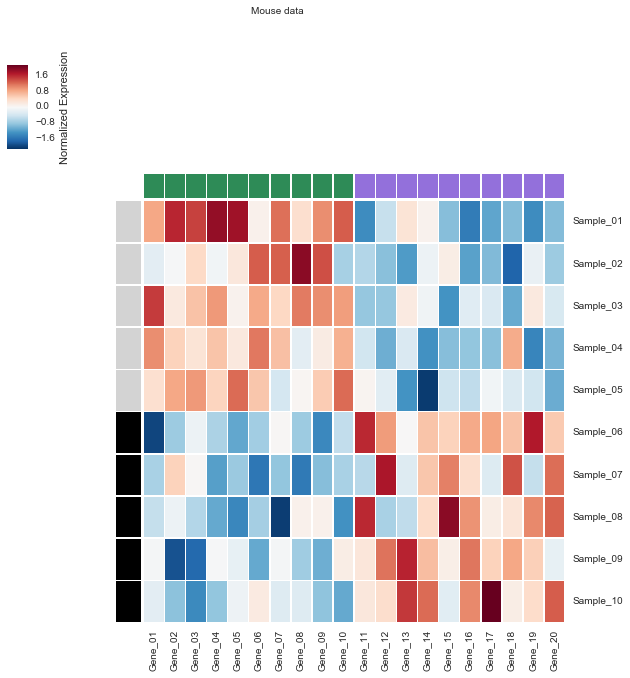

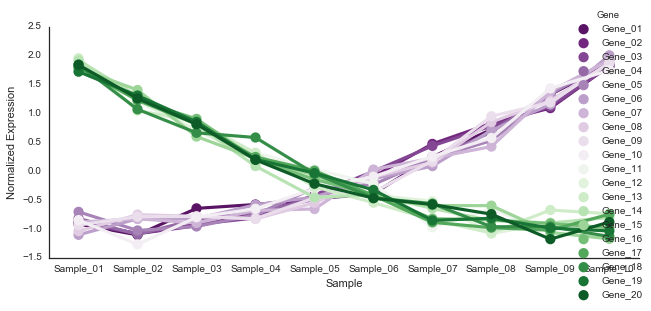

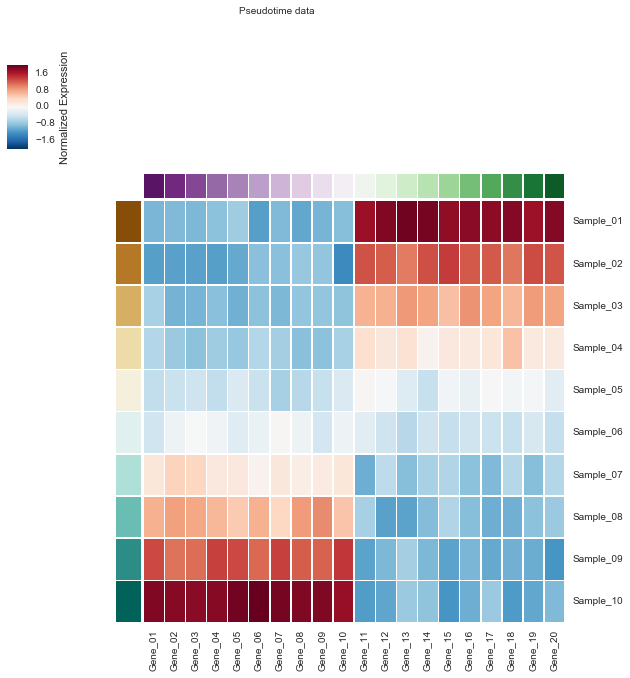

In [15]:
from time import time

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import seaborn as sns
sns.set(context='notebook', style='white')

%matplotlib inline

np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

mouse_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add biological variance
mouse_data.iloc[:half_samples, :half_genes] += 1
mouse_data.iloc[:half_samples, half_genes:] += -1
mouse_data.iloc[half_samples:, half_genes:] += 1
mouse_data.iloc[half_samples:, :half_genes] += -1

# Z_score within genes
mouse_data = (mouse_data - mouse_data.mean())/mouse_data.std()

# Biological samples
mouse_groups = pd.Series(dict(zip(mouse_data.index, (['Mouse_01'] * int(n_samples/2)) + (['Mouse_02'] * int(n_samples/2)))), 
                         name="Mouse")
mouse_groupby = pd.Series(mouse_groups.index, index=mouse_groups.values)
mouse_palette = ['lightgrey', 'black']
mouse_to_color = dict(zip(['Mouse_01', 'Mouse_02'], mouse_palette))
mouse_colors = [mouse_to_color[mouse_groups[x]] for x in samples]

# Gene colors
gene_colors = (['SeaGreen'] * half_genes) + (['MediumPurple'] * half_genes)
mouse_row_colors = mouse_colors
mouse_col_colors = gene_colors 

g = sns.clustermap(mouse_data, row_colors=mouse_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=mouse_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Mouse data')

np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

pseudotime_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add "psueodotime"
pseudotime_data.iloc[:, :half_genes] = pseudotime_data.iloc[:, :half_genes].add(np.square(np.arange(n_samples)/2), axis=0)
pseudotime_data.iloc[:, half_genes:] = pseudotime_data.iloc[:, half_genes:].add(np.square(np.arange(n_samples)[::-1]/2), axis=0)


# Normalize genes using z-scores
pseudotime_data = (pseudotime_data - pseudotime_data.mean())/pseudotime_data.std()

pseudotime_row_colors = sns.color_palette('BrBG', n_colors=n_samples)
pseudotime_col_colors = sns.color_palette("PRGn", n_colors=n_genes)
pseudotime_palette = pseudotime_row_colors
tidy = pseudotime_data.unstack().reset_index()
tidy = tidy.rename(columns={'level_0': 'Gene', 'level_1': "Sample", 0:'Normalized Expression'})
tidy.head()

g = sns.factorplot(data=tidy, hue='Gene', palette=pseudotime_col_colors, x='Sample', 
                   y='Normalized Expression', aspect=2)
# g.map(plt.plot, x='Sample', y='Normalized Expression')


g = sns.clustermap(pseudotime_data, row_colors=pseudotime_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=pseudotime_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Pseudotime data')

In [17]:
%pdb

Automatic pdb calling has been turned ON


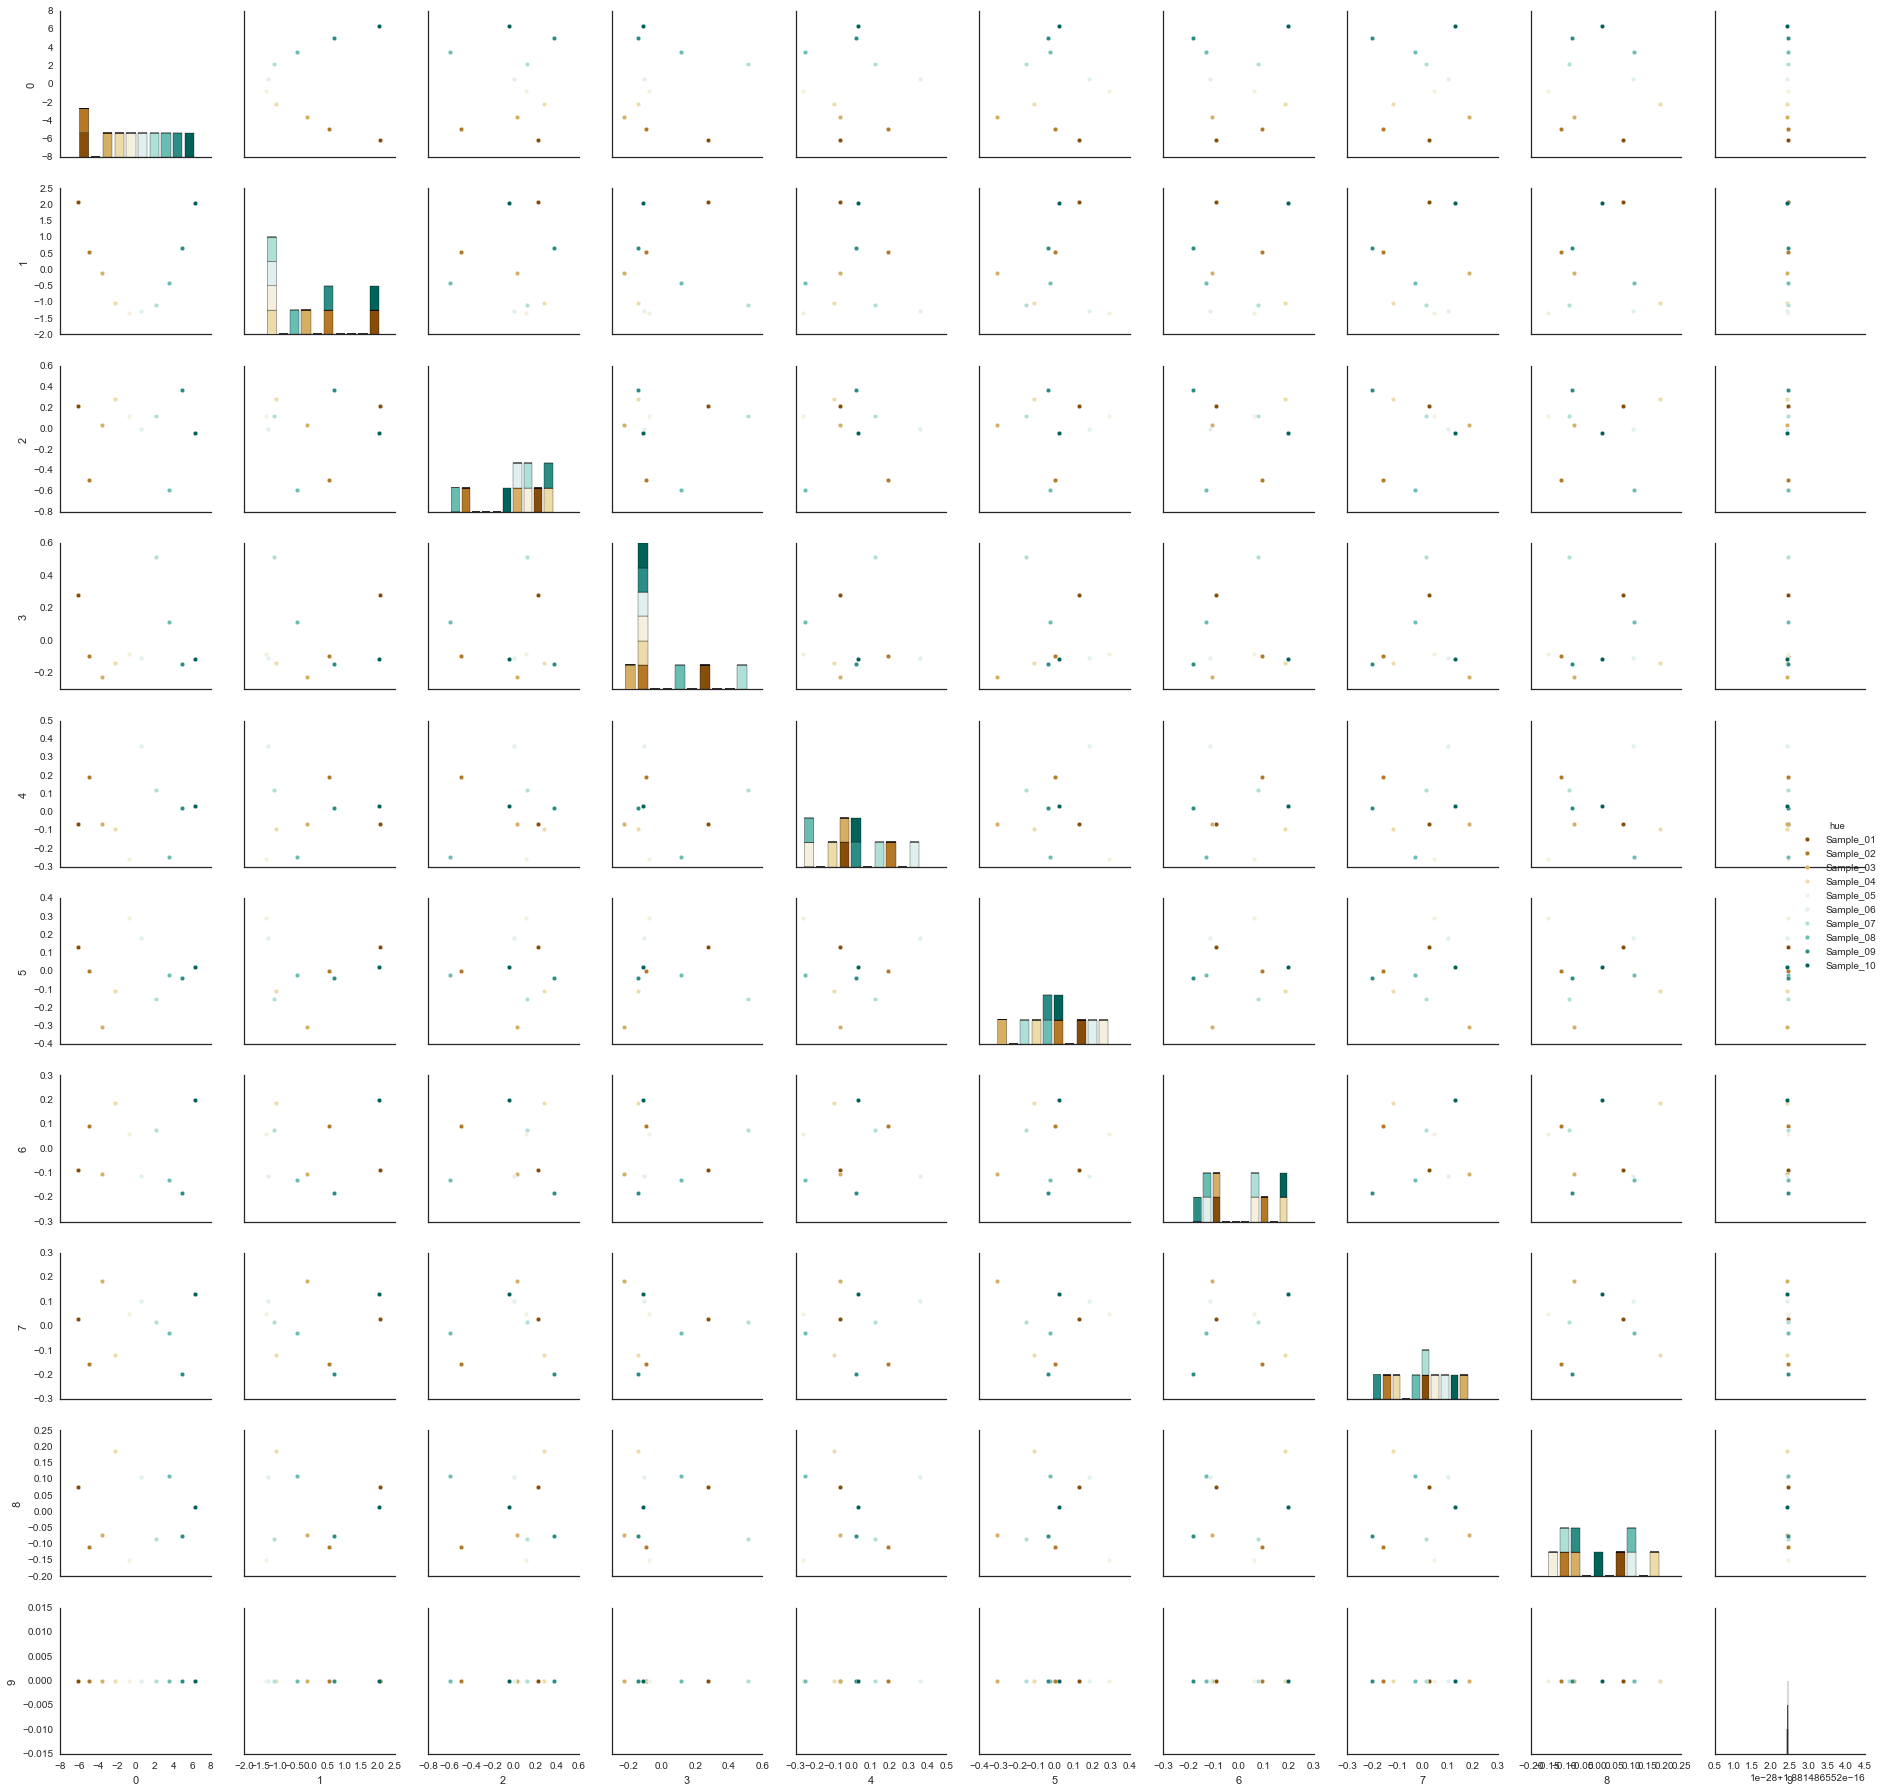

In [20]:
methods = [
           'Matrix decomposition: PCA',
           'Matrix decomposition: ICA',
          ]


def explore_clustering(dataset, method, n_components):
    if dataset == 'Mouse':
        data = mouse_data
        row_colors = mouse_row_colors
        col_colors = mouse_col_colors
        hue = mouse_groups.copy()
        palette = mouse_palette
    elif dataset == 'Pseudotime':
        data = pseudotime_data
        row_colors = pseudotime_row_colors
        col_colors = pseudotime_col_colors
        hue = pd.Series(data.index, index=data.index)
        palette = pseudotime_palette
    hue.name = 'hue'

    # Copy the full name of the method
    fullname = str(method)
    if method.startswith('Clustering'):
        method = method.split()[-1]
        t0 = time()
        g = sns.clustermap(data, row_colors=row_colors, method=method,
                           xticklabels=[], yticklabels=[])
        g.fig.suptitle('{} linkage of the digits (time {:.2f}s)'.format(fullname, time()-t0))
        
    else:
        max_iter = 100
        random_state = 0
        n_init = 1
        if method.endswith('PCA'):
            estimator = decomposition.PCA(n_components=n_components)
        elif method.endswith('ICA'):
            estimator = decomposition.FastICA(max_iter=max_iter, n_components=n_components, 
                                              random_state=random_state)
        t0 = time()
        smushed = estimator.fit_transform(data)
        smushed = pd.DataFrame(smushed, index=data.index)
        smushed = smushed.join(hue)
        title = "{} embedding of the {} (time {:.2f}s)".format(fullname, dataset, time() - t0)
        sns.pairplot(smushed, hue='hue', palette=palette)
#         fig, ax = plt.subplots()

#         ax.scatter(smushed[:, 0], smushed[:, 1], color=row_colors, s=40)
#         ax.set(title=title)
#         sns.despine()


ipywidgets.interact(explore_clustering,
                    dataset=ipywidgets.Dropdown(options=['Mouse', 'Pseudotime'], value='Mouse', 
                                               description='Dataset'),
                    metric=ipywidgets.Dropdown(options=['euclidean', 'cityblock', ], value='euclidean', 
                                               description='Distance metric'),
                    method=ipywidgets.Dropdown(options=methods, value='Matrix decomposition: PCA', 
                                               description='Unsupervised learning method'),
                    n_components=ipywidgets.IntSlider(min=2, max=10, value=4));

## Discussion questions

1. What do additional components of PCA reveal?
2. How does the number of ICA components affect the mouse data? The pseudotime data?